In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torchvision

In [2]:
!wget  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

--2024-05-16 08:45:35--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.38.88, 52.217.232.0, 54.231.135.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.38.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  44.3MB/s    in 7.8s    

2024-05-16 08:45:43 (42.0 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]



# **Read data from files**

---



In [3]:
!mkdir "102flowers"
!tar -xf flower_data.tar.gz -C "102flowers"

In [4]:
import os

base_dir = "102flowers"
train_path = os.path.join(base_dir, "train")
test_path = os.path.join(base_dir, "test")
val_path = os.path.join(base_dir, "valid")


Do some transfors (RandomRotation, RandomHorizontalFlip) on data to make learning better

In [5]:
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


train_ds = datasets.ImageFolder(train_path, transform=train_transforms)
val_ds = datasets.ImageFolder(val_path, transform=val_transforms)

train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dloader = DataLoader(val_ds, batch_size=batch_size)

In [6]:
# each batch has 32 data and each image composed 224*224 pixels and 3 channels
next(iter(train_dloader))[0].size()

torch.Size([32, 3, 224, 224])

(-0.5, 1809.5, 905.5, -0.5)

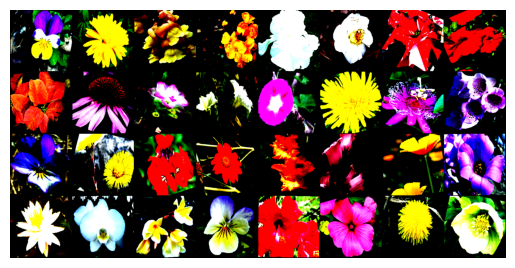

In [7]:
import matplotlib.pyplot as plt

# Look at some flowers
imgs, _ = next(iter(train_dloader))
img_grid = torchvision.utils.make_grid(imgs, nrow=8)
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis("off")

In [8]:
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 54.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# freeze paramaters so we don't backpropagate update through them
for param in model.parameters():
    param.requires_grad = False

# write my classifier
classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 102),
)

# replace my classifier
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
learning_rate = 0.001

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [13]:
from tqdm import tqdm

num_epochs = 20

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_loss, val_loss = 0.0, 0.0
    model.train()

    for batch_indx, (imgs, labels) in enumerate(tqdm(train_dloader)):
        imgs, labels = imgs.to(device), labels.to(device)
        predictions = model(imgs)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    for imgs, labels in val_dloader:
        imgs, labels = imgs.to(device), labels.to(device)
        predictions = model(imgs)
        loss = criterion(predictions, labels)

        val_loss += loss.item()

    train_loss_history.append(train_loss/len(train_dloader))
    val_loss_history.append(val_loss/len(val_dloader))
    print(f"Epoch {epoch + 1}/{num_epochs} | train loss: {train_loss/len(train_dloader)} | val loss: {val_loss/len(val_dloader)}")

100%|██████████| 205/205 [01:14<00:00,  2.76it/s]


Epoch 1/20 | train loss: 3.2837439275369413 | val loss: 1.5727008443612318


100%|██████████| 205/205 [01:15<00:00,  2.72it/s]


Epoch 2/20 | train loss: 2.2567946306089075 | val loss: 1.3508252788048525


100%|██████████| 205/205 [01:13<00:00,  2.80it/s]


Epoch 3/20 | train loss: 2.050801655141319 | val loss: 1.062269155222636


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 4/20 | train loss: 1.928777845022155 | val loss: 1.1761191074664776


100%|██████████| 205/205 [01:14<00:00,  2.75it/s]


Epoch 5/20 | train loss: 1.7887757362388983 | val loss: 1.0814497648523405


100%|██████████| 205/205 [01:13<00:00,  2.80it/s]


Epoch 6/20 | train loss: 1.7390727144915883 | val loss: 1.0264195553385294


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 7/20 | train loss: 1.7503629262854414 | val loss: 1.0230051814936674


100%|██████████| 205/205 [01:13<00:00,  2.80it/s]


Epoch 8/20 | train loss: 1.6411158204078675 | val loss: 0.9984959438443184


100%|██████████| 205/205 [01:14<00:00,  2.77it/s]


Epoch 9/20 | train loss: 1.649361178642366 | val loss: 0.9524538886661713


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 10/20 | train loss: 1.6867968501114263 | val loss: 1.1081348600295873


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 11/20 | train loss: 1.6736991989903334 | val loss: 0.874797464778217


100%|██████████| 205/205 [01:13<00:00,  2.80it/s]


Epoch 12/20 | train loss: 1.5873824448120304 | val loss: 1.0144411004506624


100%|██████████| 205/205 [01:14<00:00,  2.76it/s]


Epoch 13/20 | train loss: 1.466567104764101 | val loss: 0.9447784435290557


100%|██████████| 205/205 [01:13<00:00,  2.77it/s]


Epoch 14/20 | train loss: 1.6701125620341883 | val loss: 0.9652715425651807


100%|██████████| 205/205 [01:13<00:00,  2.81it/s]


Epoch 15/20 | train loss: 1.5891729936367127 | val loss: 0.9894394450462781


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 16/20 | train loss: 1.5188274075345296 | val loss: 0.9188929018206321


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 17/20 | train loss: 1.5953158106018857 | val loss: 0.7969409313339454


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


Epoch 18/20 | train loss: 1.5648886183413064 | val loss: 0.9341542268028626


100%|██████████| 205/205 [01:14<00:00,  2.77it/s]


Epoch 19/20 | train loss: 1.5539497484521168 | val loss: 0.8966283442255539


100%|██████████| 205/205 [01:13<00:00,  2.80it/s]


Epoch 20/20 | train loss: 1.5304522668443075 | val loss: 1.0061220443592622
